In [1]:
import networkx as nx # version 2.2
import matplotlib.pyplot as plt
import re
import cvxpy as cp
import operator #to sort elements in a list of tuples
import itertools
import math
import numpy as np
import os
import sys
import time
import random

import Init_NetRate as Init
import cvxpy as cp
import Cascade_generation_functions_NetRate as Gen
import CVX_functions as cvx

In [2]:
network_file_name = "./Graph_test_SG.txt"
cascade_file_name = "./Cascade_test_SG.txt"
window = 10
eps = 0.0005
alpha_max = 10
model=0
beta = 1
iter_ADMM = 10

In [3]:
G_true = Init.Load_ground_truth(network_file_name)
G_star, DAG_C_dic = Init.Init(cascade_file_name)
N = G_true.number_of_nodes()

All nodes were read


In [4]:
# G_true = Gen.Generate_random_graph(100,200)
# Cascades = Gen.Generate_all_cascades(G_true,-1000,window,model,beta)
# Gen.Save_cascade_to_file("Cascade_test_ADMM.txt",Cascades,G_true)
# Gen.Save_graph_to_file("Graph_test_ADMM.txt",G_true)
# G_star,DAG_C_dic = Init.Init("Cascade_test_ADMM.txt")
# N = G_true.number_of_nodes()

In [22]:
(A_pot,A_bad),num_casc_per_node = cvx.Create_matrices_ADMM(G_true,DAG_C_dic,window)
A_hat = np.zeros((N,N))
u = 0.6


# Start ADMM

In [23]:
t_start_global = time.time()
dic_of_obj_per_node_per_iter = {}
obj_per_node = []
for i in G_true.nodes :
    t_start_node_i = time.time()
    dic_of_obj_per_node_per_iter[i] = []
    try :
        cascade_list = num_casc_per_node[i]
    except KeyError :
        A_hat[:,i] =0
        continue
#     rho = np.ones((len(DAG_C_dic),1))*0.0005
    rho = np.zeros((len(DAG_C_dic),1))
    a_0 = np.ones(N)
    S_i = np.zeros((len(DAG_C_dic),1))
    S_init = np.zeros((len(DAG_C_dic),1))
    print("Node : ",i)
    a_hat = cp.Variable(N)
    constr = [a_hat>=0]
    S_admm = cp.Parameter((len(DAG_C_dic),1))
    rho_admm = cp.Parameter((len(DAG_C_dic),1))
    
    #Compute objective function 
    obj = 0
    for j in G_true.nodes :
        if A_pot[j,i]>0:
            obj += a_hat[j]*(A_pot[j,i]+A_bad[j,i]) # to do double check the signe
        else :
            constr.append(a_hat[j]==0)
    for casc in cascade_list : # not sure about this one. It may be DAG_C_dic instead of cascade_list
        c = DAG_C_dic[casc]
        tmp = 0
        S_0 = 0
        if i in c.nodes:
            parent_i_c = list(c.predecessors(i))
            for papa in parent_i_c :
                tmp += a_hat[papa]
                S_init[casc] +=a_0[papa] 
        obj += rho_admm[casc]*tmp # to do double check the signe
        obj += u/2 * cp.power((S_admm[casc]-tmp),2)       
   
    #Start iteration of ADMM
    for k in range(0,iter_ADMM) :
        if k!=0 :
            S_admm.value = S_i
        else :
            S_admm.value = S_init #Initial value of S
        rho_admm.value = rho
        '''
        update alpha_i
        '''
        objf = cp.Minimize(obj)
        prob = cp.Problem(objf,constr)
        res = prob.solve(warm_start = True)
        if prob.status!="optimal":
            print(prob.status)
        a_k = a_hat.value
        for index,alpha in enumerate(a_k):
            if alpha<0:
                a_k[index]=0
            if alpha>alpha_max :
                a_k[index] = alpha_max
        '''
        update S_i and rho for each cascades via the closed form formula and the gradient descent respectively
        '''
        for cascs in DAG_C_dic :
            c = DAG_C_dic[cascs]
            Malpha = 0
            if i in c.nodes :
                parent_i_c = list(c.predecessors(i))
                for papa in parent_i_c :
                    Malpha += a_k[papa]
            sqrt_delta = math.sqrt((rho[cascs]+u*Malpha)**2 + 4*u)
            S_i[cascs] = ((rho[cascs]+u*Malpha)+sqrt_delta)/(2*u)
            if S_i[cascs]<0 :
                print("Huston Huston we have a probleme")
            rho[cascs] = rho[cascs]-u*(S_i[cascs]-Malpha)
            
        '''compute the objective function for node i in iteration k'''
        obj_i_k = 0
        for c in DAG_C_dic :
            cascade = DAG_C_dic[c]
            sum_tmp = 0
            for j in cascade.nodes():
                t_j = cascade.nodes[j]["time"]
                if a_k[j]<0:
                        a_k[j]=0
                if (j,i) in cascade.edges():
                    t_i = cascade.node[i]["time"]
                    obj_i_k += -a_k[j]*(t_i-t_j)
                    if a_k[j]<eps:
                        sum_tmp += eps
                    else:
                        sum_tmp += a_k[j]
                    
                if j in cascade.nodes() and i not in cascade.nodes():
                    obj_i_k += -a_k[j]*(window-t_j)
            if sum_tmp >0:
                obj_i_k += math.log(sum_tmp)
        dic_of_obj_per_node_per_iter[i].append(obj_i_k)
    obj_per_node.append(obj_i_k)
    print("Total objective function value is : ",sum(obj_per_node))
    A_hat[:,i] = a_k

    t_end_node_i = time.time()
    print("computation time for node i : ", t_end_node_i-t_start_node_i)
t_end_global = time.time()
print("total computation time : ",t_end_global-t_start_global) 

Node :  0
Total objective function value is :  -144.65505445907633
computation time for node i :  10.257320165634155
Node :  1
Total objective function value is :  -144.65505445907633
computation time for node i :  5.426237106323242
Node :  2
Total objective function value is :  -1656.8965668202998
computation time for node i :  61.02834486961365
Node :  3
Total objective function value is :  -1699.129325886466
computation time for node i :  5.286371469497681
Node :  4
Total objective function value is :  -3152.5258373398997
computation time for node i :  68.38953685760498
Node :  5
Total objective function value is :  -4183.791818276523
computation time for node i :  63.30201077461243
Node :  6
Total objective function value is :  -4234.099795565772
computation time for node i :  5.598385810852051
Node :  7
Total objective function value is :  -4876.742234968606
computation time for node i :  59.05677795410156
Node :  8
Total objective function value is :  -6931.7966511524455
computat

Total objective function value is :  -67198.84665152196
computation time for node i :  59.66687750816345
Node :  73
Total objective function value is :  -68793.49077319787
computation time for node i :  65.96701908111572
Node :  74
Total objective function value is :  -69175.2602227058
computation time for node i :  34.103986501693726
Node :  75
Total objective function value is :  -69566.70676449186
computation time for node i :  46.045196294784546
Node :  76
Total objective function value is :  -73607.54362031475
computation time for node i :  74.82015347480774
Node :  77
Total objective function value is :  -73807.07701527173
computation time for node i :  16.74100160598755
Node :  78
Total objective function value is :  -75864.71570930629
computation time for node i :  68.76200699806213
Node :  79
Total objective function value is :  -76677.09962062883
computation time for node i :  46.17365837097168
Node :  80
Total objective function value is :  -77002.86857236343
computation tim

Total objective function value is :  -127402.77169626177
computation time for node i :  45.21340370178223
Node :  143
Total objective function value is :  -128419.19348568756
computation time for node i :  56.58222246170044
Node :  144
Total objective function value is :  -128731.699422612
computation time for node i :  43.943172454833984
Node :  145
Total objective function value is :  -130230.22560965818
computation time for node i :  56.80504274368286
Node :  146
Total objective function value is :  -132112.36043938098
computation time for node i :  62.83377170562744
Node :  147
Total objective function value is :  -134247.79236689178
computation time for node i :  61.08739757537842
Node :  148
Total objective function value is :  -134247.79236689178
computation time for node i :  5.359776496887207
Node :  149
Total objective function value is :  -134327.6428923582
computation time for node i :  5.745667934417725
Node :  151
Total objective function value is :  -134327.6428923582
co

In [20]:
'''
Precision and recall computation
'''
correct = 0
edge_G_star = list(G_star.edges())
G_star.remove_edges_from(edge_G_star)
for i in range(0,G_true.number_of_nodes()):
    for j in range(0,G_true.number_of_nodes()):
        if A_hat[i,j] >eps:
            G_star.add_edge(i,j)
            if (i,j) in G_true.edges():
                correct +=1
#                 print("edge ",(i,j))
#                 print("alpha is ",A_hat[i,j])
print("Precision :",correct/G_star.number_of_edges())
print("Recall :",correct/G_true.number_of_edges())
print("Number of correct infered edges : ",correct)
print("Number of edges in G_hat :",G_star.number_of_edges())
print("Number of edges in the true network ",G_true.number_of_edges())
        

Precision : 0.14863713798977854
Recall : 0.8725
Number of correct infered edges :  349
Number of edges in G_hat : 2348
Number of edges in the true network  400


In [21]:
'''
mean square error
'''
mse = 0
nb_correcte_edges=0
for edge in G_true.edges():
    if edge in G_star.edges():
        nb_correcte_edges +=1
        try:
            true_alpha = G_true.edges[edge]["weight"][0]
        except TypeError:
            true_alpha = G_true.edges[edge]["weight"]
        approx_alpha = A_hat[edge[0],edge[1]]
        mse += pow((true_alpha-approx_alpha),2) # mean square error
#         print("For edge " + str(edge)+ " the true weight is : " + str(true_alpha))
#         print("For edge " + str(edge)+ " the approx weight is : " + str(approx_alpha))
try :
    mse = mse/nb_correcte_edges
except ZeroDivisionError:
    print ("There is no correct edge")
print(" Mean square error is : ",mse)

 Mean square error is :  62.724938418455636


node :  126


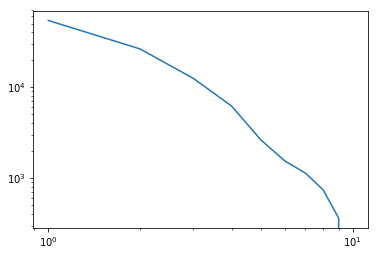

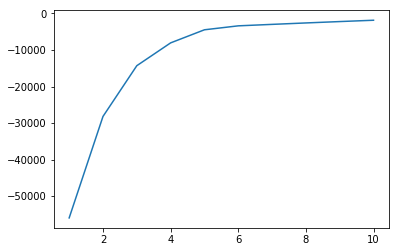

In [17]:
rand_nod = random.choice(list(G_true.node()))
print("node : ",rand_nod)
last = dic_of_obj_per_node_per_iter[rand_nod][-1]
times = [last-x for x in dic_of_obj_per_node_per_iter[rand_nod]]
plt.loglog(list(range(1,iter_ADMM+1)),times)
plt.show()
plt.plot(list(range(1,iter_ADMM+1)),dic_of_obj_per_node_per_iter[rand_nod])
plt.show()

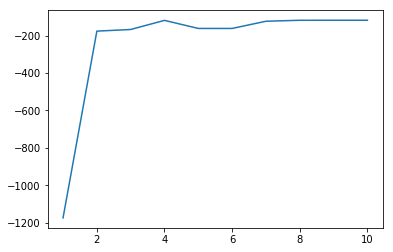